<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Logistic Regression

In [2]:
# Import the libraries we know we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore")

We are going to use a dataset from the University of Wisconsin which contains features of the cell nuclei present in biopsies of breast masses.  Our objective with this exercise is to predict is whether a mass from a biopsy is malignant or benign, based on characteristics of the cells.  Description of the dataset can be found here: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

In [3]:
from sklearn.datasets import load_breast_cancer
data=load_breast_cancer(as_frame=True)
X,y=data.data,data.target
# Since the default in the file is 0=malignant 1=benign we want to reverse these so 1=malignant, which is what we want to identify
y=(y==0).astype(int)
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


First let's split our data and reserve a test set of 20% of the data for use in evaluating our model.  Then, to help things converge we will use `StandardScaler` to scale our data before modeling (not necessary in this case, but helpful)

In [4]:
# Let's set aside a test set and use the remainder for training and cross-validation
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.2)

# Let's scale the inputs to help it converge more easily
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic regression using Scikit Learn

Scikit-Learn makes it very easy to create and train a logistic regression model on our data.  Note that by default the implementation of logistic regression in Scikit-Learn includes a regularization penalty factor to help reduce overfitting.  We could turn this off if we want by specifying `penalty='none'` but in this case we will leave it on.

In [8]:
# Instantiate a logistic regression model
model = LogisticRegression()
# Fit the model to the training data
model.fit(X_train_scaled,y_train)
# Use the trained model to generate predictions on the test set
test_preds = model.predict(X_test_scaled)
# Calculate the accuracy of the test set predictions
acc_score = accuracy_score(y_test,test_preds)
print('Accuracy on the test set is {:.3f}'.format(acc_score))

Accuracy on the test set is 0.965


Great! We've achieved an impressive accuracy on the test set with our logistic regression model.  Let's now visualize the decision boundary created by the model to differentiate between the two classes (0 and 1).  Since we as humans like to visualize in 2D, let's create a new model using only 2 features so we can then plot things on a 2d plot.

In [10]:
# Function to visualize the decision boundaries of a classification model
def plot_decision_boundaries(X,y,model):
    markers = ['^','s','v','o','x']
    colors = ['yellow','green','purple','blue','orange']
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    for i,k in enumerate(np.unique(y)):
        plt.scatter(X.loc[y==k].iloc[:,0],X.loc[y==k].iloc[:,1],
                    c=colors[i],marker=markers[i],label=k,edgecolor='black')

    xgrid = np.arange(X.iloc[:,0].min(),X.iloc[:,0].max(),
                      (X.iloc[:,0].max()-X.iloc[:,0].min())/500)
    ygrid = np.arange(X.iloc[:,1].min(),X.iloc[:,1].max(),
                      (X.iloc[:,1].max()-X.iloc[:,1].min())/500)
    xx,yy = np.meshgrid(xgrid,ygrid)
    mesh_preds = model.predict(np.c_[xx.ravel(),yy.ravel()])
    mesh_preds = mesh_preds.reshape(xx.shape)
    plt.contourf(xx,yy,mesh_preds,alpha=0.2,cmap=cmap)
    plt.legend()
    return

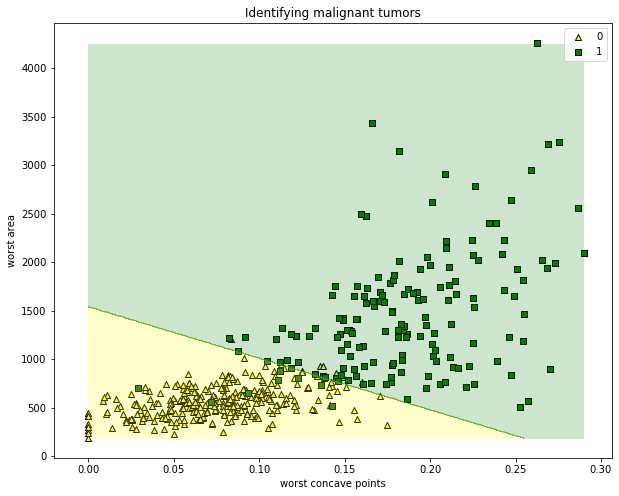

In [11]:
# Let's create a model using just two features so we can visualize it
X_train_2feats = X_train[['worst concave points','worst area']]
model_2feats = LogisticRegression(penalty='none')
model_2feats.fit(X_train_2feats,y_train)

# Plot the decision boundaries of the model using the two features as the axes
plt.figure(figsize=(10,8))
plot_decision_boundaries(X_train_2feats,y_train,model_2feats)
plt.xlabel('worst concave points')
plt.ylabel('worst area')
plt.title('Identifying malignant tumors')
plt.show()

As we can see, the decision boundary between malignant and benign tumors created by our model is a straight line.  This makes sense, because logistic regression is a linear model (because it uses a linear combination of the features multiplied by the weights).

If you are curious about how to create a logistic regression model by hand rather than using Scikit-Learn, keep reading below.  Otherwise, you can skip to the "Multiclass logistic regression" section.

## [OPTIONAL] Logistic regression using batch gradient descent

In [5]:
def sigmoid(z):
    # Calculate the sigmoid
    sig = 1. / (1. + np.exp(-z))
    #sig = 1. / (1. + np.exp(-np.clip(logits,-100,100)))
    return sig

def NLL_batch_gradient_descent(X,y,weights,learning_rate,n_iterations):
    # Perform gradient descent to calculate weights that minimize the NLL cost function
    epsilon = 1e-10 # Add tiny value to avoid getting nan values from log(0)
    cost_path = []
    for i in range(n_iterations):
        # Calculate the cost
        z = X.dot(weights)
        cost = -np.sum(y*(np.log(sigmoid(z)+epsilon))+(1.-y)*(np.log(1.-sigmoid(z)+epsilon)))
        # OR USE LINALG: cost = -(y.dot(np.log(sigmoid(z)+epsilon))+(1.-y).dot(np.log(1.-sigmoid(z)+epsilon)))
        cost_path.append(cost)
        # Calculate the gradient
        gradient = -X.T.dot(y-sigmoid(z))
        # Adjust the weights, moving in the direction opposite the gradient
        weights = weights - learning_rate * gradient
    return weights,cost_path

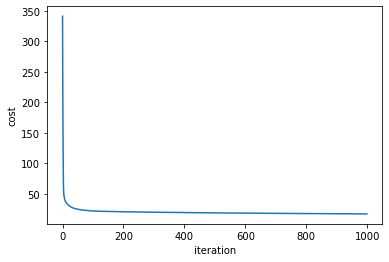

In [6]:
# Run gradient descent to get the weights that minimize our cost NLL
n_iterations = 1000
learning_rate = 0.01

# Initialize the weights to random numbers
rand_gen = np.random.RandomState(1)
weights_init = rand_gen.normal(loc=0.0,scale=0.1,size=X_train.shape[1])

# Run logistic regression with gradient descent
weights_opt,cost_path = NLL_batch_gradient_descent(X_train_scaled,y_train,weights_init,
                                                       learning_rate,n_iterations)
plt.plot(range(n_iterations),cost_path)
plt.xlabel('iteration')
plt.ylabel('cost')
plt.show()

In [9]:
# Use our model to generate predictions and calculate accuracy
test_preds_probs = sigmoid(X_test_scaled.dot(weights_opt))

# Convert predicted probabilities to class predictions
test_preds = np.round(test_preds_probs).astype(int)

acc_score = accuracy_score(y_test,test_preds)
print('Accuracy is {:.3f}'.format(acc_score))

Accuracy is 0.965


## Multiclass logistic regression (Softmax regression)

To demonstrate how to create a multiclass linear regression in Scikit-Learn, we will use the "iris" dataset we have seen before of iris flowers.  This dataset contains 4 features of the flowers and our objective is to classify the flowers into one of three species of iris.

In order to visualize what is going on, we are going to use a subset of just two of the four features for our model so that we can plot the decision boundaries it creates between the three classes.

In [15]:
# Load the dataset using a helper function in Seaborn
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [16]:
# What are the target classes?
pd.unique(iris['species'])

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [17]:
# Create feature matrix using just 2 features
X = iris[['sepal_length','sepal_width']]

# Create target vector and convert to numeric codes (not required, but used for visualization)
y = iris['species']
y_numeric_dict={'setosa':1,'versicolor':2,'virginica':3}
y = y.apply(lambda x: y_numeric_dict[x])

# Split into training and test sets
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.2)

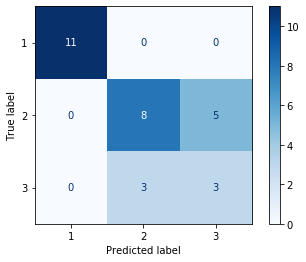

In [18]:
# Train a multi-class softmax regression model and get the test set predictions
model = LogisticRegression(penalty='l2',C=1.0,multi_class='multinomial')
model.fit(X_train,y_train)
test_preds = model.predict(X_test)

# Display the confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues,normalize=None)
plt.show()

As we can see on the confusion matrix, our model is doing a pretty good job differentiating between the three species.  It seems to struggle a bit between classes 2 (versicolor) and 3 (virginica).  Let's now use our function to visualize the decision boundaries between the three classes.

In [20]:
# Visualize the decision boundaries
def plot_decision_boundaries(X,y,model):
    markers = ['^','s','v','o','x']
    colors = ['yellow','green','purple','blue','orange']
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    for i,k in enumerate(np.unique(y)):
        plt.scatter(X.loc[y==k].iloc[:,0],X.loc[y==k].iloc[:,1],
                    c=colors[i],marker=markers[i],label=k,edgecolor='black')

    xgrid = np.arange(X.iloc[:,0].min(),X.iloc[:,0].max(),
                      (X.iloc[:,0].max()-X.iloc[:,0].min())/500)
    ygrid = np.arange(X.iloc[:,1].min(),X.iloc[:,1].max(),
                      (X.iloc[:,1].max()-X.iloc[:,1].min())/500)
    xx,yy = np.meshgrid(xgrid,ygrid)
    mesh_preds = model.predict(np.c_[xx.ravel(),yy.ravel()])
    mesh_preds = mesh_preds.reshape(xx.shape)
    plt.contourf(xx,yy,mesh_preds,alpha=0.2,cmap=cmap)
    plt.legend()
    return

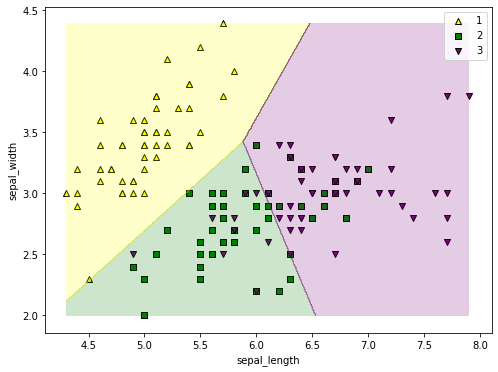

In [21]:
# Plot the decision boundary using our function
plt.figure(figsize=(8,6))
plot_decision_boundaries(X,y,model)
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.show()

Above we can see the decision boundaries that our logistic regression model has created, using the two features to differentiate between the three classes of iris. The shading of each region represents the predicted class of that region, and the color and shape of the symbol used for each point shows us the actual class of each point.